# Markowitz Portfolio Optimization with Python

By Daniel Kerim Acatay

In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
#import xarray as xr
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 50
pd.options.display.max_rows = 6
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

# Introduction

Modern Portfolio Theory (MPT) greatly influenced how investors and portfolio managers perceive risk, return and diversification effects since its introduction in 1952 by Henry Markowitz. Portfolio optimization becomes relevant when different financial assets are bundled into a portfolio. In order to find the optimal portfolio constellation one should not only aim for the highest expected return possible. Instead, one should consider the underlying risk profiles of the financial assets when constructing the optimal portfolio.

In this Notebook we will motivate the need for portfolio optimization with regard to the risk and return profiles of real asset portfolios. In particular, this notebook features a hands-on implementation of Quadratic Programming with Python using the <code>cvxopt</code> module to find an optimal financial asset portfolio. This will be done for an artificial as well as a real economic data set of daily stock returns.


# Part 1: Obtaining Time Series Data

## Artificial Data

For the artificial data set we construct four time series, each with 1000 randomly sampled observations from a standard normal distribution. The artificial data will mimick the behavior of actual financial asset returns.

In [2]:
np.random.seed(1)

# length of artificial time series
n_obs = 1000

# number of different assets
n_assets = 4

# sample Nx4 data series matrix
artificial_returns = np.random.randn(n_obs, n_assets) + 0.05
artificial_returns

array([[ 1.67435, -0.56176, -0.47817, -1.02297],
       [ 0.91541, -2.25154,  1.79481, -0.71121],
       [ 0.36904, -0.19937,  1.51211, -2.01014],
       ...,
       [ 0.12342,  0.46603, -1.8292 ,  0.62546],
       [ 0.15206,  1.2343 , -0.74484, -0.0759 ],
       [-0.91035, -0.79391,  0.67834,  0.58721]])

To get a first impression of the data we use standard techniques: simple lineplots of the data as well as the cumulative sum of each series. The cumulative sum provides a comparative description of the observed time series.

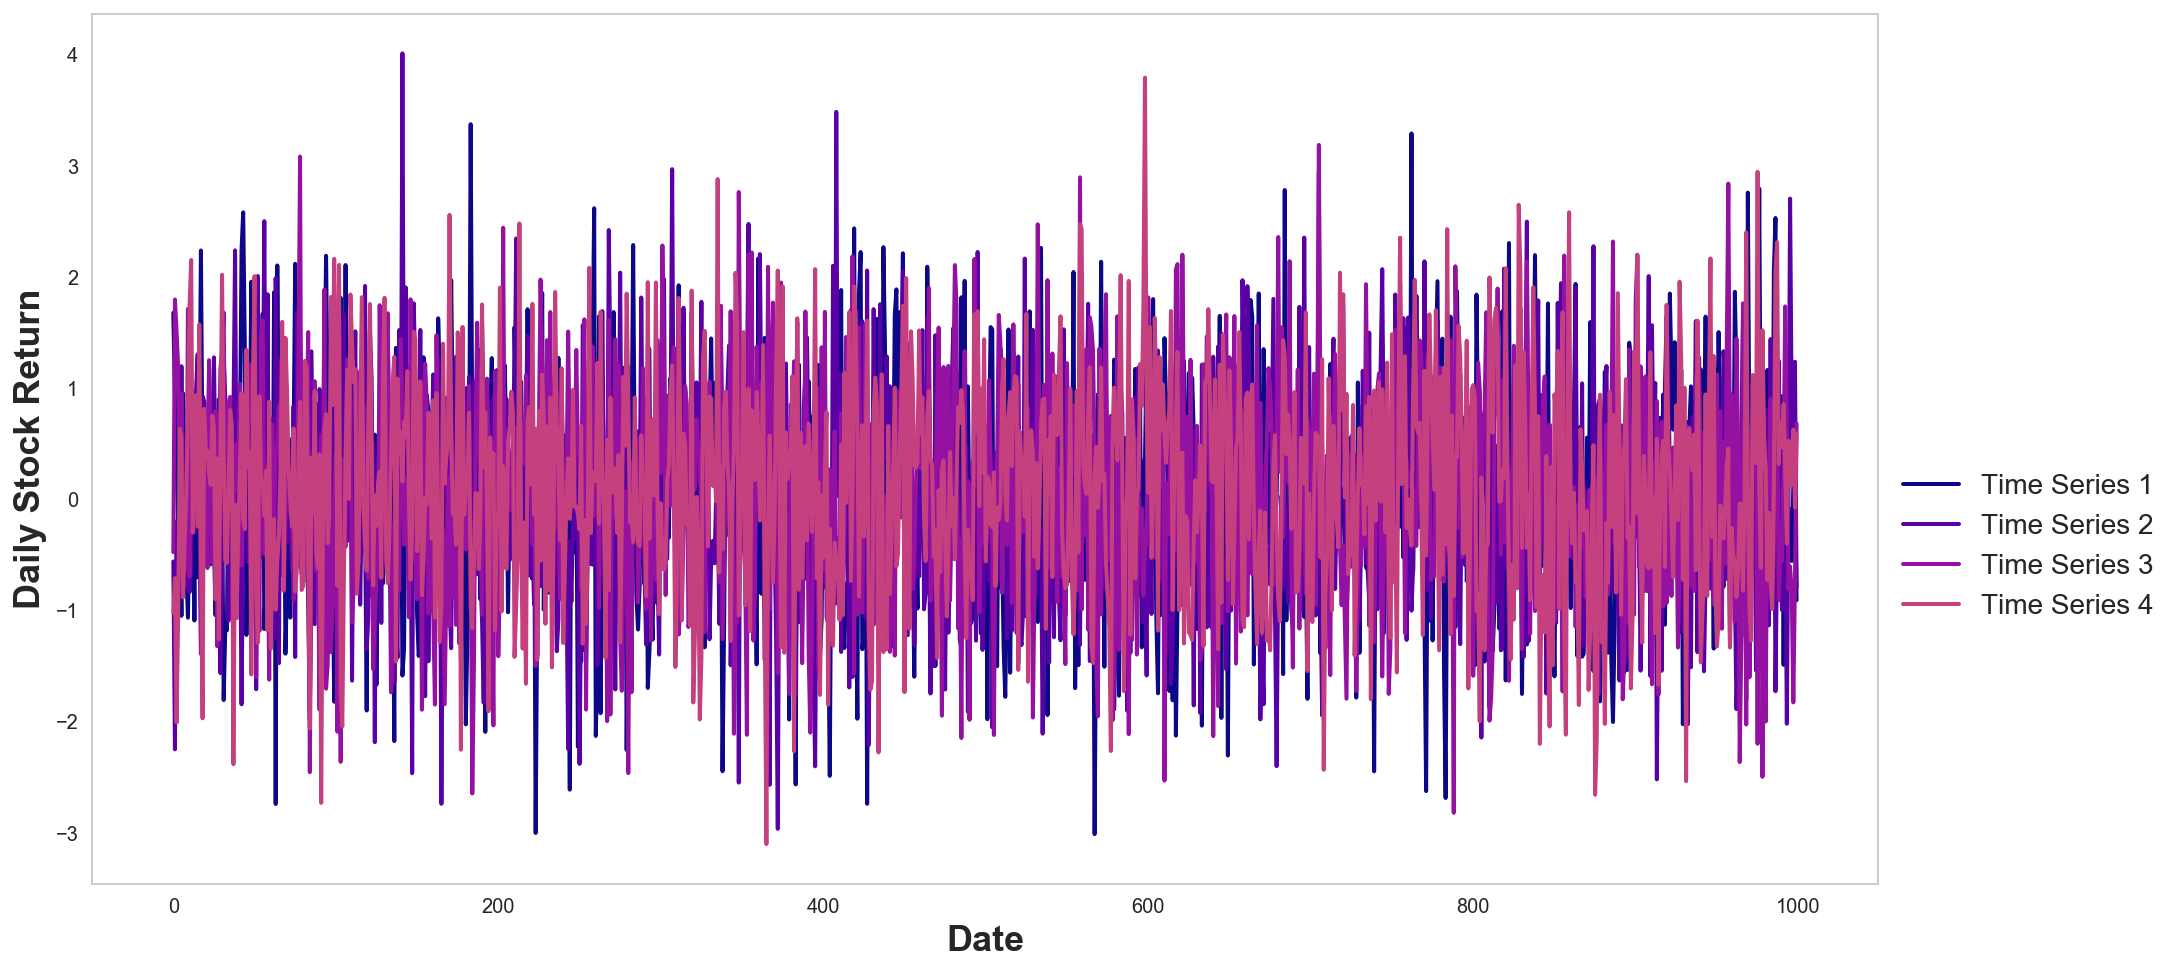

In [4]:
# get colormap
colors = plt.cm.plasma(np.linspace(0,3,20))

# plot data
for i in range(artificial_returns.shape[1]):
    plt.plot(artificial_returns.T[i], color=colors[i], label='Time Series {}'.format(i + 1));
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5));
plt.xlabel('Date');
plt.ylabel('Daily Stock Return');

plt.show()

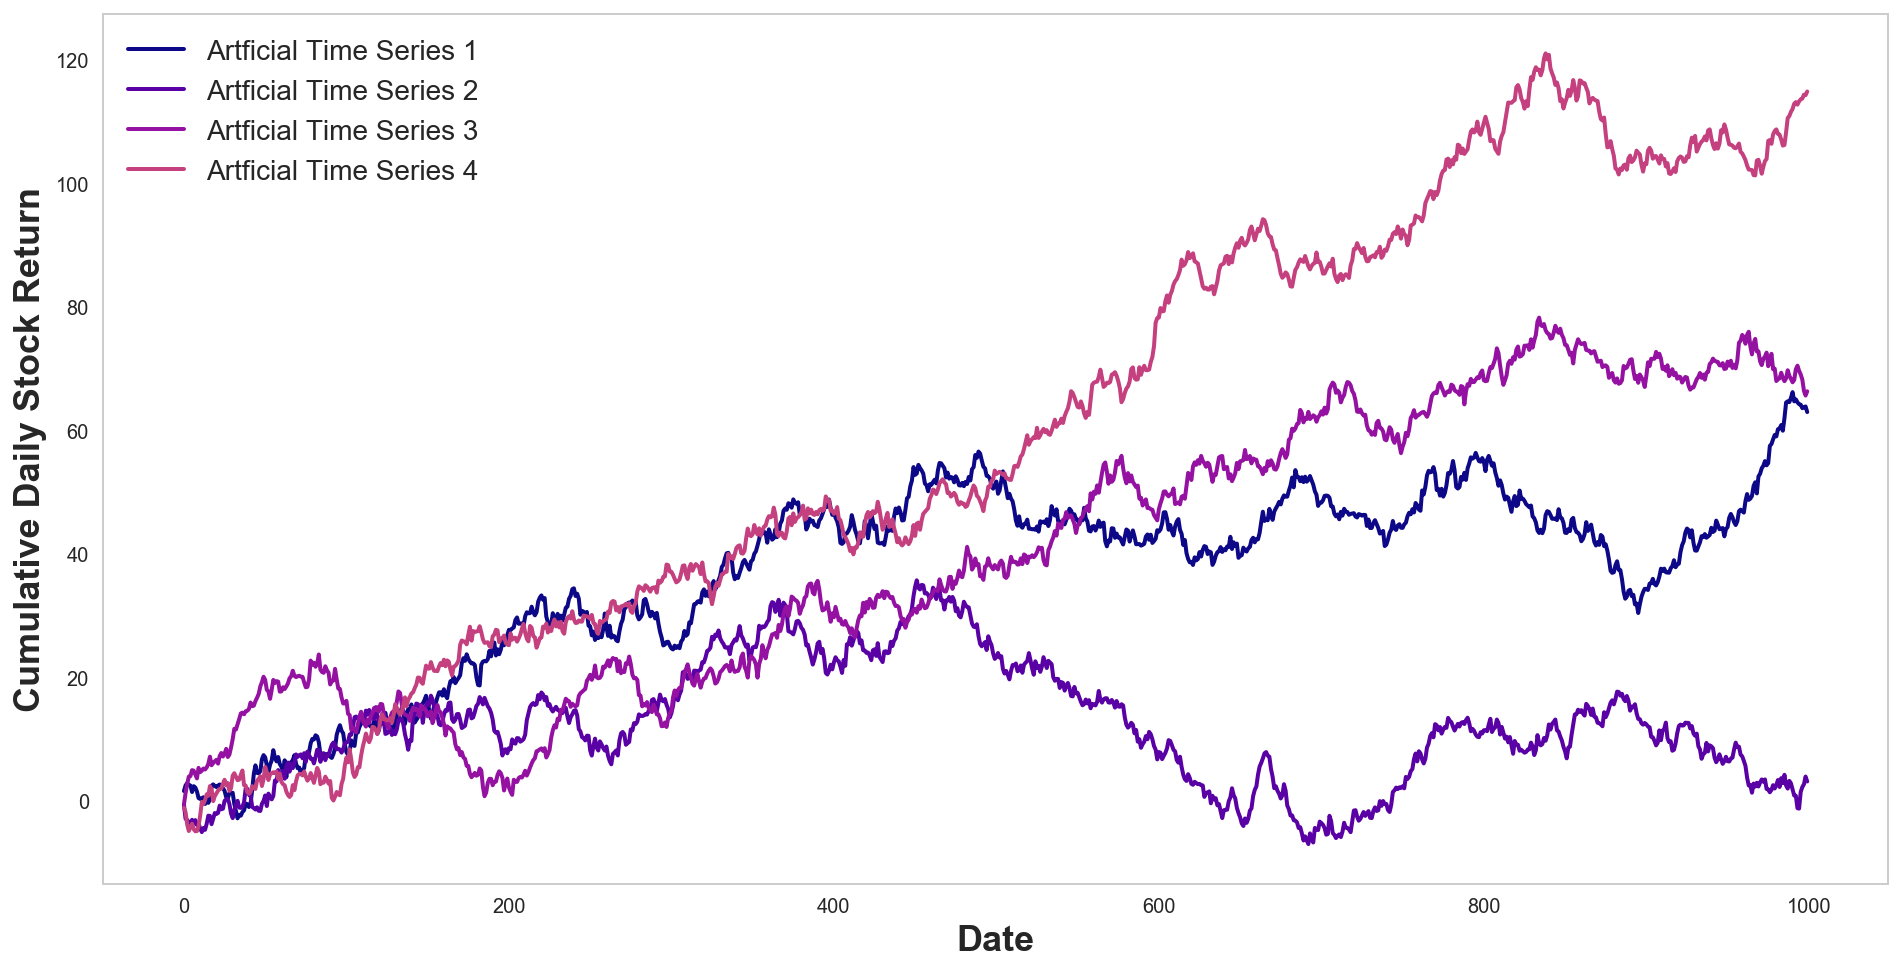

In [6]:
# get colormap
colors = plt.cm.plasma(np.linspace(0,3,20))

# plot cumulative sums
for i in range(artificial_returns.shape[1]):
    plt.plot(artificial_returns.T[i].cumsum(), color=colors[i], label='Artficial Time Series {}'.format(i + 1));
plt.legend(loc='best');
plt.xlabel('Date');
plt.ylabel('Cumulative Daily Stock Return');

plt.show()

## Download Economic Time Series Data

To obtain an economic time series data set we use the <code>pandas_datareader</code> module to access the API of financial data providers like Yahhoo! Finance, Google Finance, or the Fred. We are interested in the adjusted close prices of S&P 100 companies. Adjusted close prices are the standard close price quotes adjusted by corporate actions that have an effect on the stocks closing price, e.g. stock splits or dividend payments.

Since the computation time needed to calculate risk and return of a portfolio containing shares of all S&P 100 copanies will be way too high, we trim the analysis on real data to a selected set of companies: Microsoft, Walmart, Procter & Gamble and General Motors.

In [8]:
# define data to be downloaded
tickers = list(pd.read_csv('./SP100_LIST.csv', sep=';')['Symbol'])
provider = 'yahoo'
start = '2010-01-01'
end = '2017-11-14'

In [124]:
# download data
#data = web.DataReader(tickers, provider, start)['Adj Close']
#ata.to_csv('./data_sp100.csv', sep=';') 

In [5]:
# read data from file
data = pd.read_csv('./data/data_sp100.csv', sep=';', index_col=0, header=0, parse_dates=True)

In [6]:
companies = ['MSFT', 'WMT', 'PG', 'GM']

In [7]:
# calculate returns
returns = data[companies] / data[companies].shift(1) - 1
returns = returns.fillna(method='ffill').dropna()

In [8]:
returns

,MSFT,WMT,PG,GM
Date,,,,
2010-11-19,-0.00580,0.00760,0.00047,0.00205
2010-11-22,0.00156,-0.00018,-0.00765,-0.00525
2010-11-23,-0.02371,-0.01306,-0.01495,-0.02435
...,...,...,...,...
2017-11-10,-0.00262,0.00687,0.00433,0.01306
2017-11-13,0.00072,0.00077,0.00953,0.02133
2017-11-14,-0.00262,-0.00198,0.00017,-0.01595


FileNotFoundError: [Errno 2] No such file or directory: './img/real_returns.png'

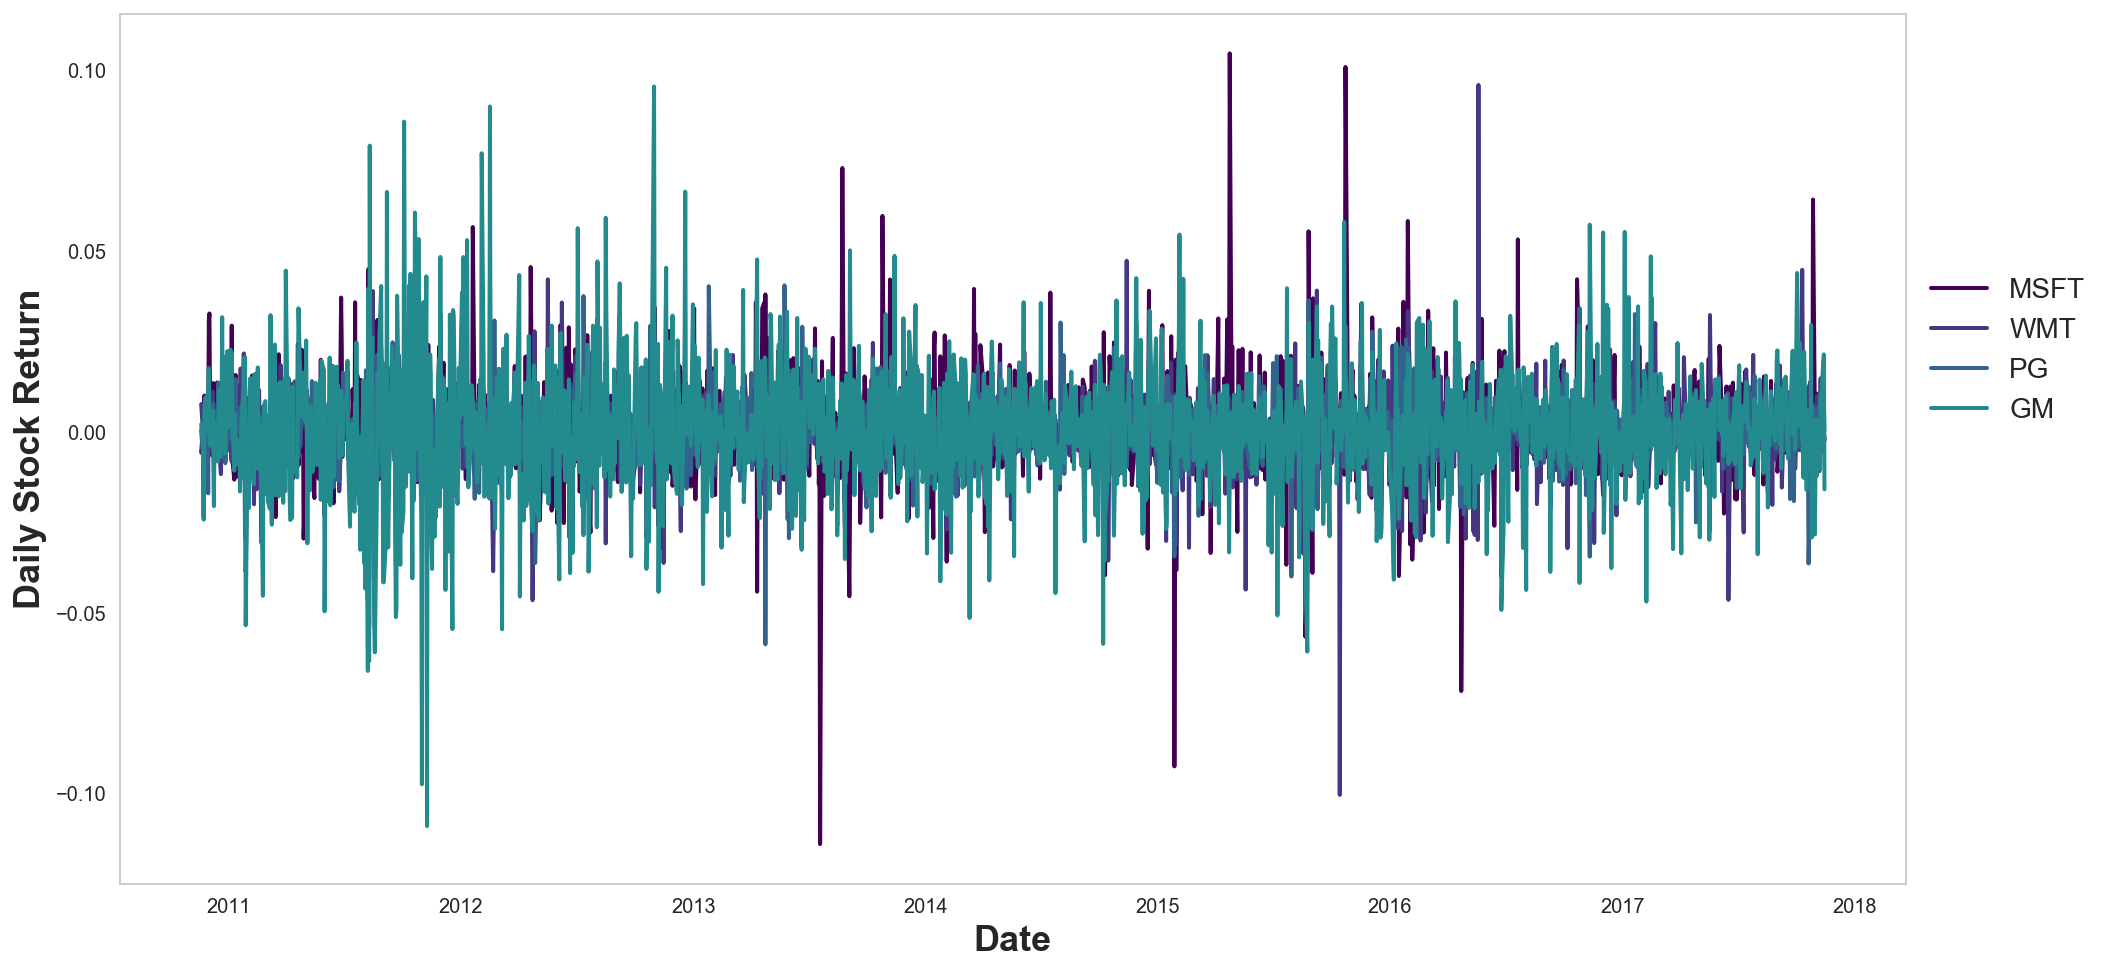

In [47]:
# get colormap
colors = plt.cm.viridis(np.linspace(0,3,20))

# plot data
for i in range(returns.shape[1]):
    plt.plot(returns.iloc[:, i], color=colors[i]);
plt.legend(loc=3, bbox_to_anchor=(1.0, 0.5));
plt.xlabel('Date');
plt.ylabel('Daily Stock Return');
plt.grid('off');

plt.show()

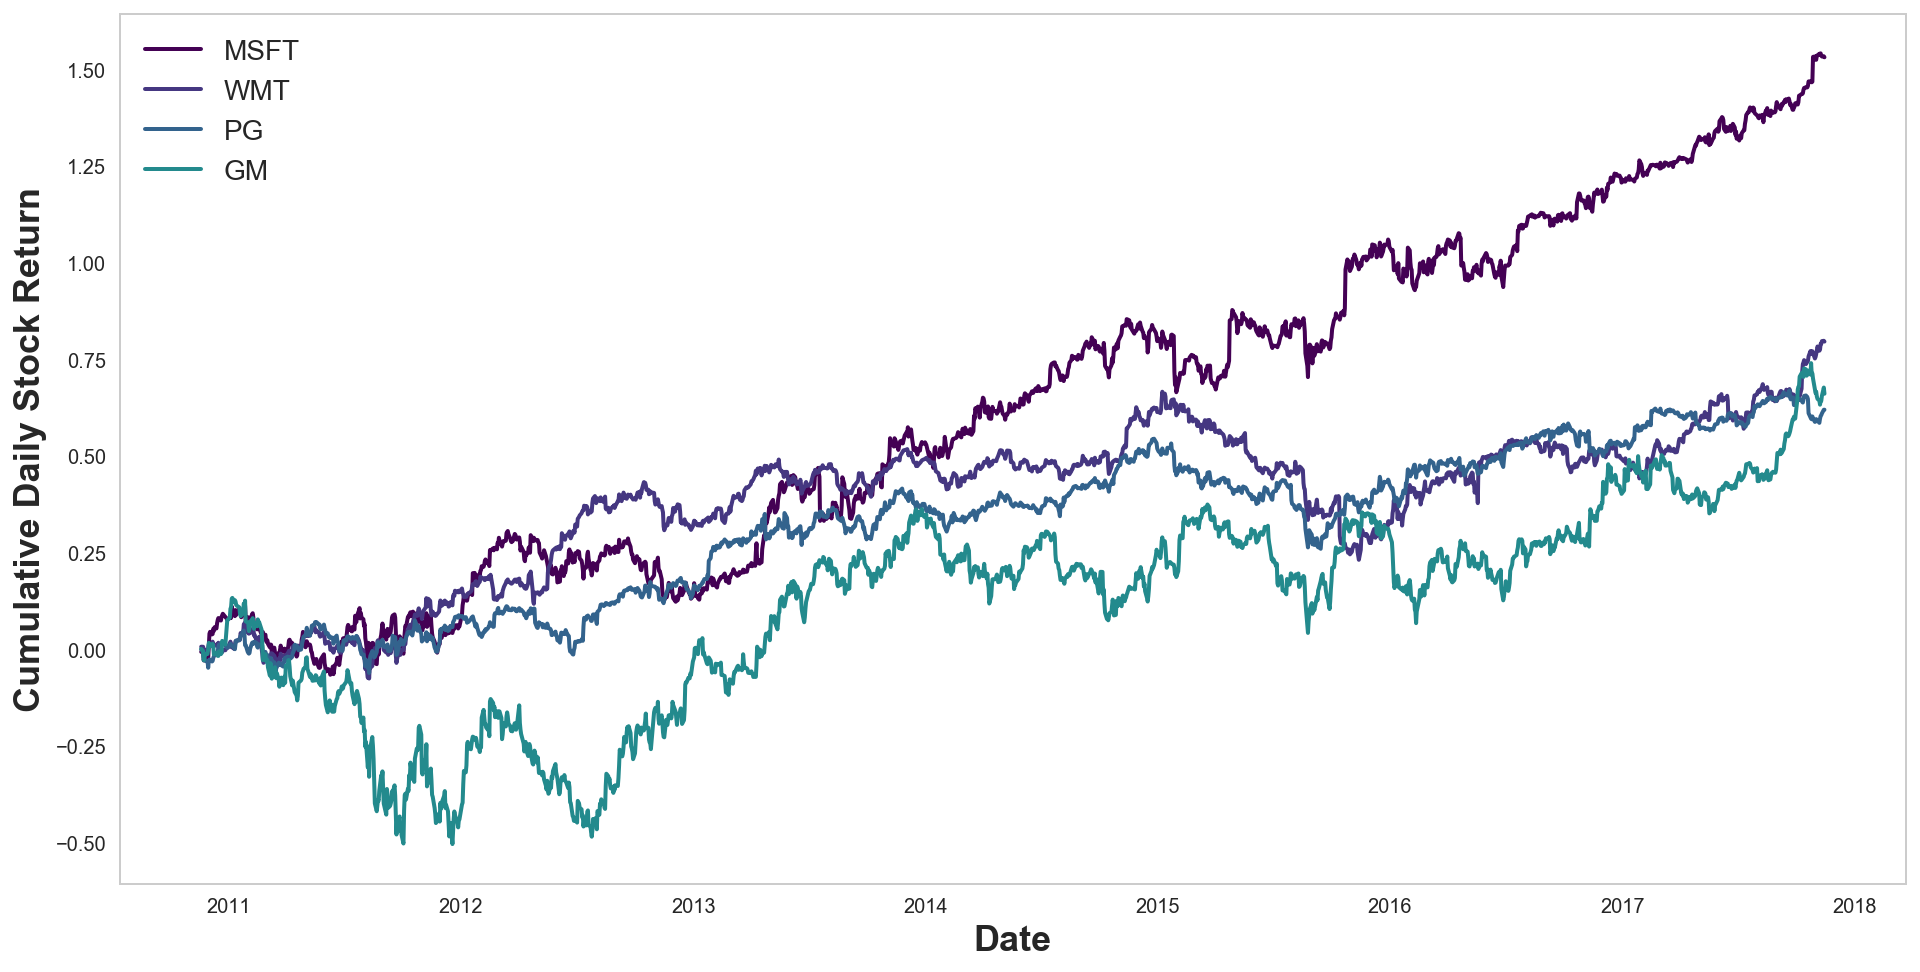

In [33]:
# get colormap viridis
colors = plt.cm.viridis(np.linspace(0,3,20))

# plot cumulative sum
for i in range(returns.shape[1]):
    plt.plot(returns.iloc[:, i].cumsum(), color=colors[i]);
plt.legend(loc='best');
plt.xlabel('Date');
plt.ylabel('Cumulative Daily Stock Return');
plt.savefig('./img/real_returns_cumsum.png')
plt.show()

Comparing the plots above we would conclude that the artificial data and the real market data might look quite similar. Do not be fooled, the underlying statistical characterstics vary greatly with regard to distributional specifics. If you want to learn more about time series analysis have a look at my <a href="https://github.com/dacatay/time-series-analysis">GitHub</a>.


# Part 2: Modern Portfolio Theory with Python

<a href="https://en.wikipedia.org/wiki/Modern_portfolio_theory">**Modern portfolio theory (MPT)**</a>, or **mean-variance analysis**, introduced by **Harry Markowitz**, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk, defined as variance. Its key insight is that an asset's risk and return should not be assessed by itself, but by how it contributes to a portfolio's overall risk and return.

## Model Assumptions

The MPT assumes that investors are rational and risk averse. That is, given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns. Conversely, an investor who wants higher expected returns must accept more risk. 

* Asset returns are normally distributed random variables.
* Investors attempt to maximize economic market returns.
* Investors are rational and avoid risk when possible.
* Investors all have access to the same sources of information for investment decisions.
* Investors share similar views on expected returns.
* Taxes and brokerage commissions are not considered.
* Investors are not large enough players in the market to influence the price.
* Investors have unlimited access to borrow (and lend) money at the risk free rate.

The above list is boldly taken from <a href="http://education.howthemarketworks.com/glossary/modern-portfolio-theory-mpt/">the web</a>. MPT assumes a lot which will most likely not be met in real life. However, the model is still market convention despite the rise of behavioral finance. This is due to its simplistic explanation of complex socio-economic phenomenons on the financial market. At the end of the day a model is just that - a model, a means of simplistic abstraction of the real world to explain a single facet of reality.


## Expected Portfolio Risk and Return

Consider an asset portfolio consisting of $i=1, \dots, N$ assets. Let $R_i$ denote the return on asset $i$ and assume that the following holds:

\begin{align}
R_i \ &\sim{iid} \ \mathcal{N}(\mu_i, \sigma_i^2) \\
\text{cov}(R_i, R_j) & = \sigma_{ij}
\end{align}

The above assumption of normality in the asset returns distribution is the theoretical crux of MPT. However, the assumption of normailty is likely to be violated in a real financial market setting.

The expected return of the portfolio $R$ is calculated by the summing the weighted expected returns for each asset $R_i$ in the portfolio:

$$
E[R_i] = \sum_{i=1}^N \omega_i \cdot R_i
$$

where $\omega_i$ are the corresponding weights of asset $i$ in the portfolio. MPT tells us that simply looking at the expected return of a portfolio is not enough. If we are interested in the comparative performance of a portfolio we additionally need to consider the volatility of the stocks within it. The portfolio variance is calcualted as

$$
\sigma_p^2 = \sum_i \omega_i^2 \sigma_i^2 + \sum_i \sum_{j \neq i} \omega_i \omega_j \sigma_i \sigma_j \rho_{ij}
$$
where $\sigma_i \sigma_j \rho_{ij} = \sigma_{ij}$ is the correlation coefficient. 


## Portfolio Characteristics with Matrix Algebra

Using matrix notation we can express our calculations more elegantely. Let the following $N \times 1$ vectors contain the asset returns and portfolio weights

$$
\textbf{R} = 
\begin{bmatrix}
R_1 \\
R_2 \\
\vdots \\
R_N \\
\end{bmatrix}, \quad
\mathbf{\omega} = 
\begin{bmatrix}
\omega_1 \\
\omega_2 \\
\vdots \\
\omega_N \\
\end{bmatrix},
$$

Under the $iid$ normality assumption all returns are jointly normally distributed and this joint distribution is completely characterized by the means, variances and covariances of the returns. The mean vector and the variance-covariance matrix of the portfolio are denoted

$$
E[\textbf{R}] = E 
\begin{bmatrix}
R_1 \\
R_2 \\
\vdots \\
R_N \\
\end{bmatrix} =
\begin{bmatrix}
E[R_1] \\
E[R_2] \\
\vdots \\
E[R_N] \\
\end{bmatrix}  =
\begin{bmatrix}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_N \\
\end{bmatrix} = \mathbf{\mu}, \quad
\Sigma = 
\begin{bmatrix}
\sigma_{11} & \sigma_{12} & \cdots & \sigma_{1N} \\
\sigma_{21} & \sigma_{22} & \cdots & \sigma_{2N} \\
\vdots & \vdots & \ddots & \vdots\\
\sigma_{N1} & \sigma_{N2} & \cdots & \sigma_{NN} \\
\end{bmatrix}.
$$

With this notation at hand, the expected portfolio return $R$ and expected portfolio variance $\sigma^2$ are calculated by:

\begin{align}
R & = \omega^T \mu \\
\sigma^2 & = \omega^T \Sigma \omega
\end{align}

The theoretics and notation are kindly borrowed from <a href="http://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf">here</a>.


## Building Available Market Portfolios

With the following functions we can create random portfolio weights which are used to construct random portfolios from the included returns series. For these randomly created portfolios we calculate the means and standard deviation, and finally plot the set of obtain random portfolios.

In [55]:
def create_random_weights(n_assets):
    '''
    returns randomly choosen portfolio weights that sum to one
    '''
    w = np.random.rand(n_assets)
    return w / w.sum()

In [56]:
def evaluate_random_portfolio(returns):
    ''' 
    returns the mean and standard deviation of returns for a random portfolio
    '''
    # in case a resampler is used
    returns = pd.DataFrame(returns)   
    
    # calculate from covariance, asset returns and weights
    cov = np.matrix(returns.cov())
    R = np.matrix(returns.mean())
    w = np.matrix(create_random_weights(returns.shape[1]))
    
    # calculate expected portfolio return and risk
    mu = w * R.T
    sigma = np.sqrt(w * cov * w.T)
    
    return mu, sigma

Function <code>evaluate_portfolio</code> implements the matrix calculation for the mean and standard deviations as shown in the formulas above.

In [57]:
def create_random_portfolios(returns, n_portfolios=1500):
    '''
    plots randomly created portfolios
    '''
    # calculate mean and std for every portfolio
    pf_mus, pf_sigmas = np.column_stack([evaluate_random_portfolio(returns) for _ in range(n_portfolios)])

    return pf_mus, pf_sigmas

Using these function, we create a set of 3000 portfolios that are optainable by randomly weighting the available assets.

In [61]:
pf_mus, pf_sigmas = create_random_portfolios(artificial_returns, n_portfolios=3000)

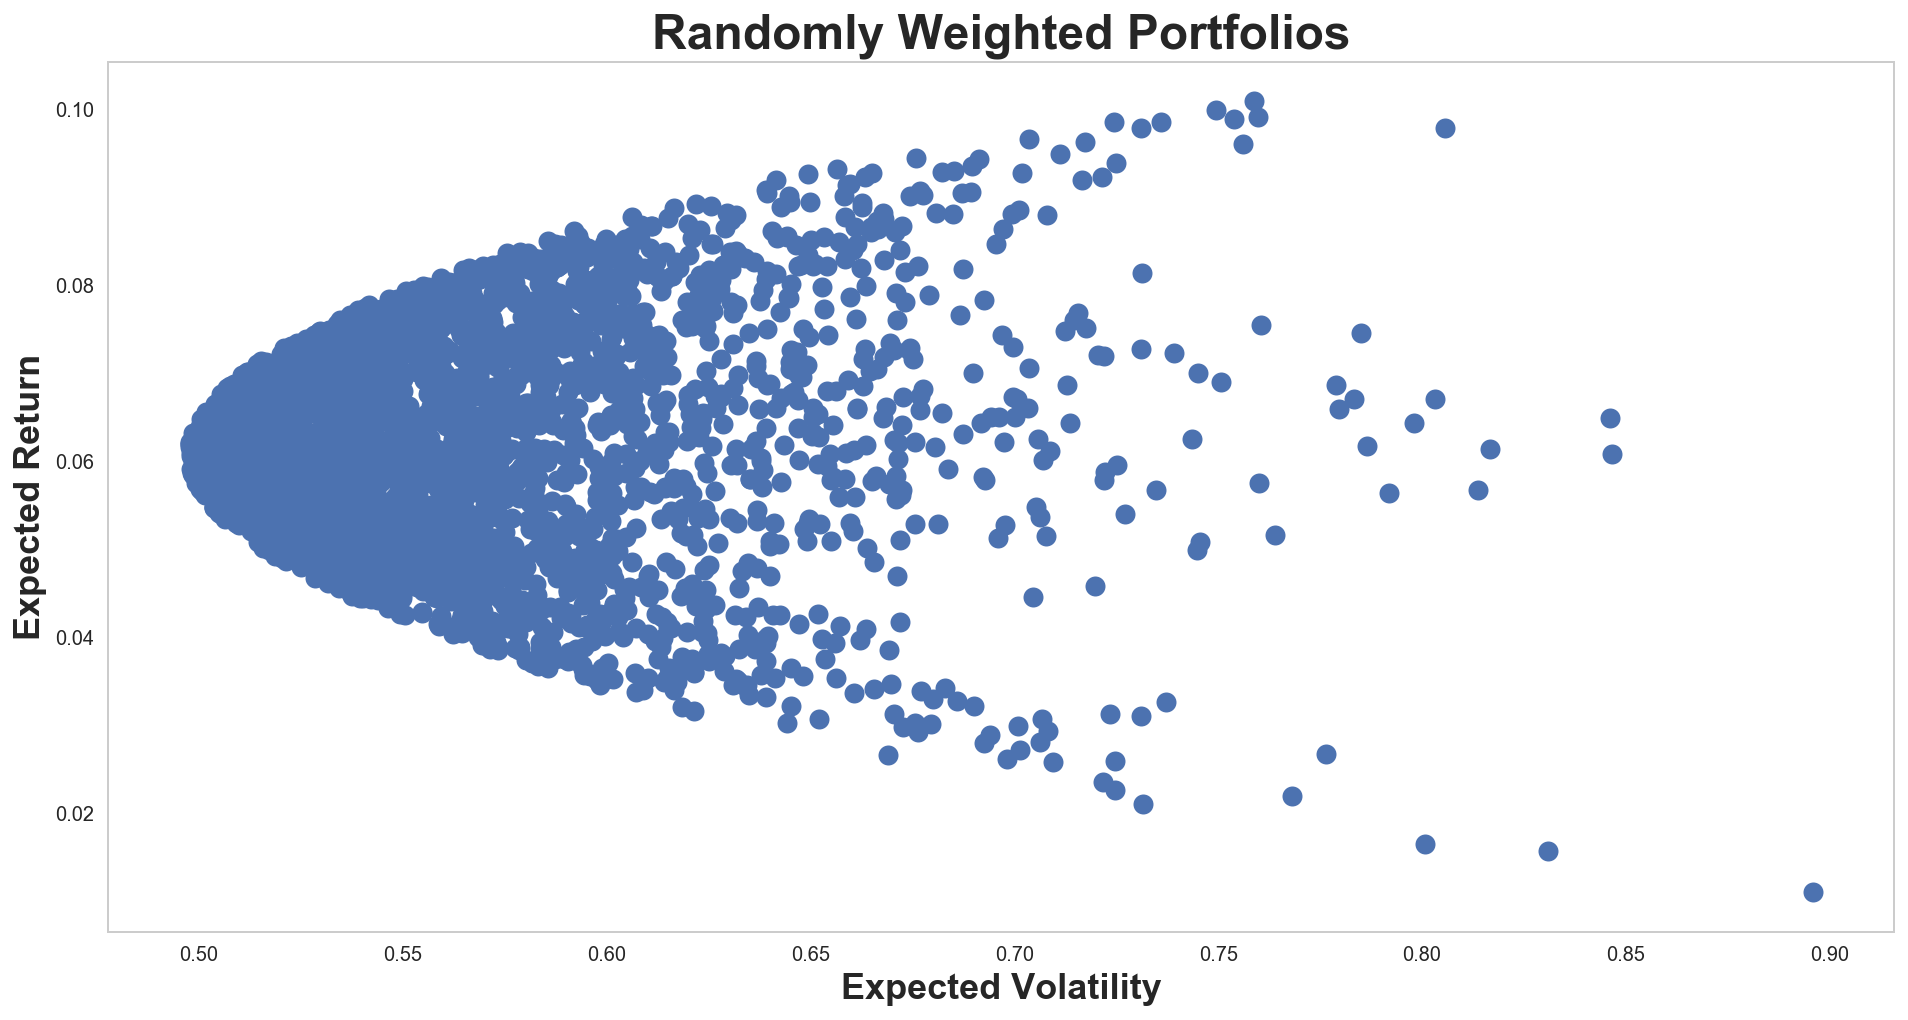

In [62]:
# scatter plot for expected return and volatility
plt.plot(pf_sigmas, pf_mus, 'o', markersize=10)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Randomly Weighted Portfolios')
plt.savefig('./img/random_portfolios.png')
plt.show()

It is easy to see that some of the randomly assembled portfolios perform better than others. The higher a point is on the Y axis the higher the expected portfolio return. The leftmost point in this plot is the least risky investment portfolio which earns exactely the average over the whole range of expected portfolio returns. Thus, if there are portfolios on the same vertical line over the X axis, the portfolios higher up on this line perform comparably better than the portfolios below, as they earn a higher expected return for the same level of risk. 


# Part 3: Efficient Market Frontier 

Remember that a rational investor will always choose the volatility minimizing portfolio for a given level of return or the return maximizing portfolio for a given level of volatility. Thus, it would make no sense to hold any portfolio other than those on the outermost surface line on the upper half of the graph. This line is called the **Efficient Market Frontier** as they earn the highest expected return possible for a certain level of risk.

To find the efficient frontier we need to minimize the variance with respect to the weight parameters for a given vector of desired returns and with regard to the assumption that all portfolio weights sum to one. This can be expressed as follows

\begin{align}
\min_{\omega} \quad \omega^T \Sigma \omega \quad \text{s.t.} \quad \mu = \omega^T \mu^* \quad \text{and} \quad \omega^T \mathbf{1} = 1
\end{align}

To solve an optimization problem with linear constraints we can make use of **<a href="https://en.wikipedia.org/wiki/Quadratic_programming">Quadratic Programming</a>**.


## Quadratic Programming

Quadratic programming is handily implemented within the module <code>cvxopt</code> which will be used in the latter. The official documentation as well as <a href="https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf">these notes</a> will help you get started with the package. For those who have trouble (like me) installing the <code>cvxopt</code> module will find this <a href="https://stackoverflow.com/questions/17905460/problems-on-installing-cvxopt">Stackoverflow link</a> helpful. Essentially, you will need to install the <code>numpy</code> distribution provided by <a href="https://www.lfd.uci.edu/~gohlke/pythonlibs/">this</a> site.

Function <code>calculate_frontier</code> returns the optimal portfolio weights, expected returns and expected standard deviation for a given return matrix. First the code defines a list of desired expected returns. This list is used to derive the optimal portfolio weights which are then used to calculate the optimal sigmas. The formulas are implemented as shown above.

In [46]:
import cvxopt as opt
from cvxopt import solvers

def calculate_frontier(returns):
    '''
    returns optimal portfolio weights and corresponding sigmas for a desired optimal portfolio return
    Params:
    - returns: T x N matrix of observed data
    '''
    returns = pd.DataFrame(returns)
    cov = np.matrix(np.cov(returns.T))
    N = returns.shape[1]
    pbar = np.matrix(returns.mean())
    
    # define list of optimal / desired mus for which we'd like to find the optimal sigmas
    optimal_mus = []
    r_min = pbar.mean()    # minimum expected return
    for i in range(50):
        optimal_mus.append(r_min)
        r_min += (pbar.mean() / 100)
    
    # constraint matrices for quadratic programming
    P = opt.matrix(cov)
    q = opt.matrix(np.zeros((N, 1)))
    G = opt.matrix(np.concatenate((-np.array(pbar), -np.identity(N)), 0))
    A = opt.matrix(1.0, (1,N))
    b = opt.matrix(1.0)
    
    # hide optimization
    opt.solvers.options['show_progress'] = False
    
    # calculate portfolio weights, every weight vector is of size Nx1
    # find optimal weights with qp(P, q, G, h, A, b)
    optimal_weights = [solvers.qp(P, q, G, opt.matrix(np.concatenate((-np.ones((1, 1)) * mu, np.zeros((N, 1))), 0)), A, b)['x'] for mu in optimal_mus]
    
    # find optimal sigma
    # \sigma = w^T * Cov * w
    optimal_sigmas = [np.sqrt(np.matrix(w).T * cov.T.dot(np.matrix(w)))[0,0] for w in optimal_weights]
    
    return optimal_weights, optimal_mus, optimal_sigmas

## Simulated Data

With the simulated data generated earlier we can find the optimal portfolios for given time series.

In [47]:
# calculate mus and sigmas for all and the optimal portfolios
pf_mus, pf_sigmas = create_random_portfolios(artificial_returns, n_portfolios=3000)
optimal_weights, optimal_mus, optimal_sigmas = calculate_frontier(artificial_returns)

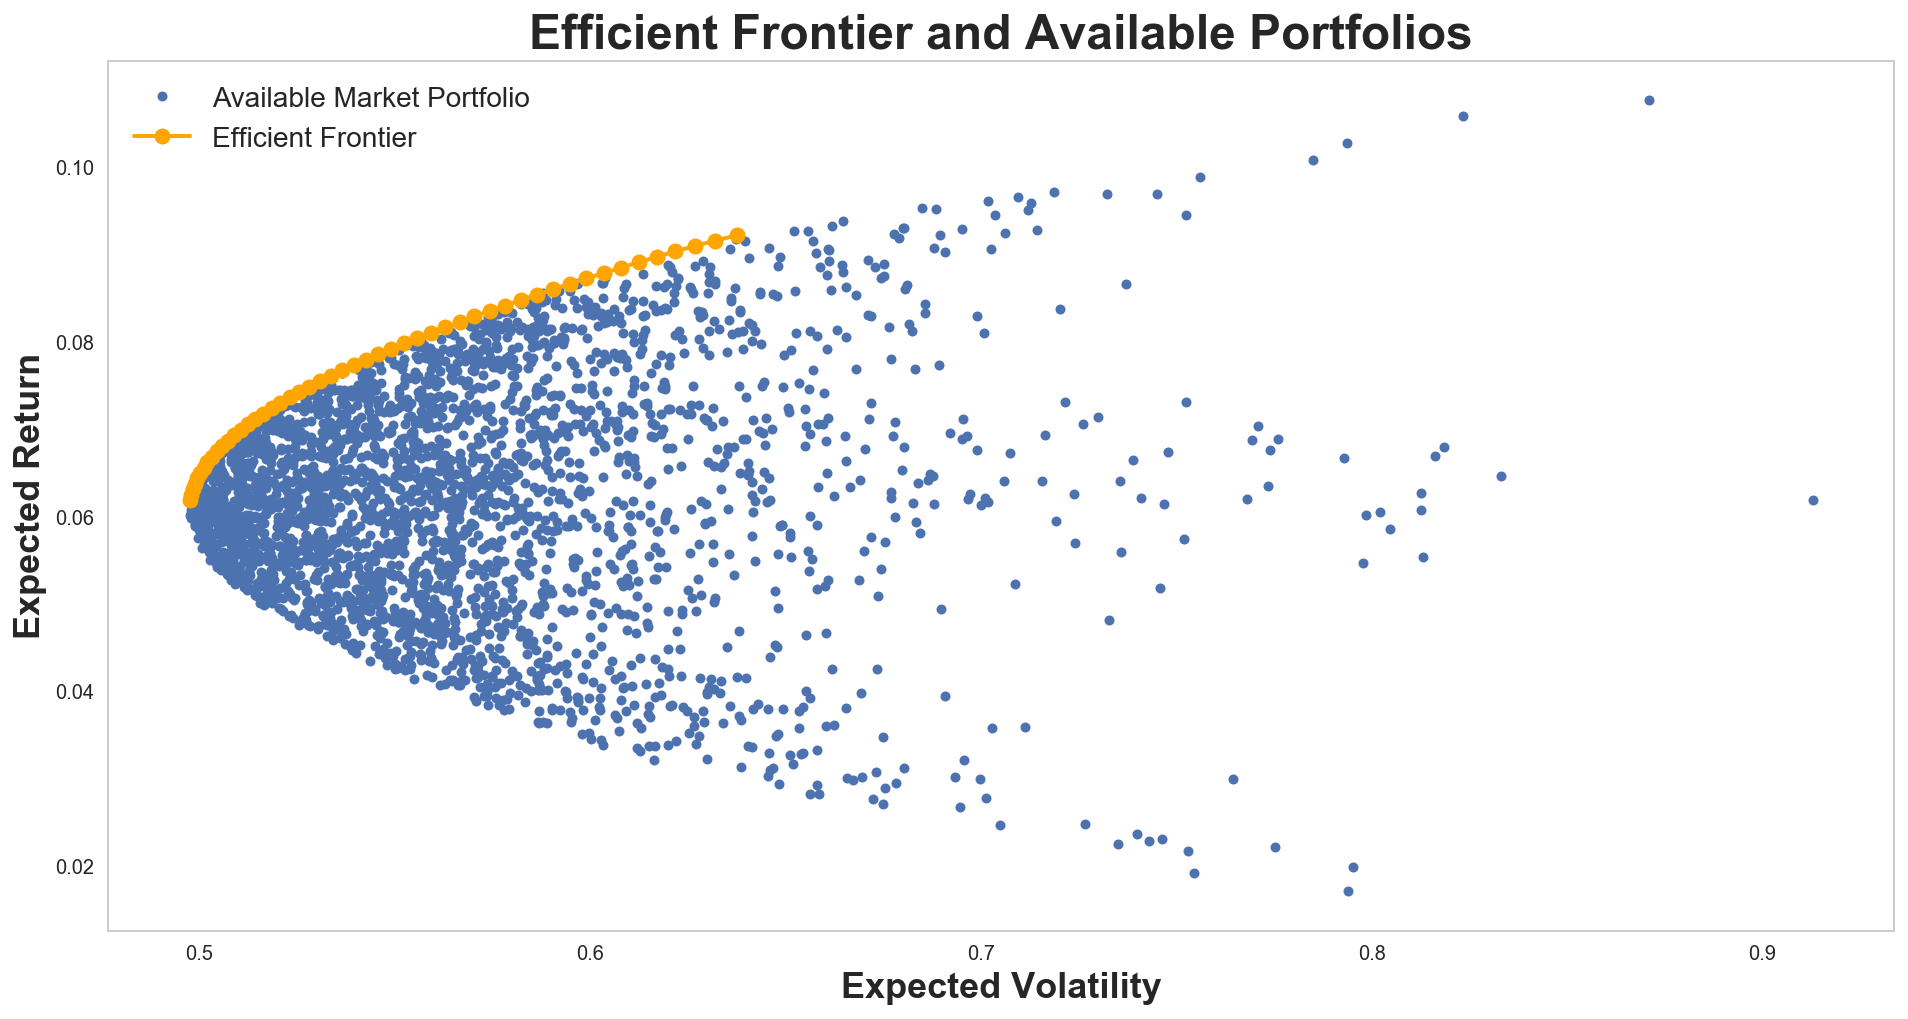

In [53]:
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(optimal_sigmas, optimal_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.savefig('./img/frontier_artificial.png')
plt.show()

The orange line indicates the set of efficient market portfolios, that is, those portfolios that have minimal risk for a given level of expected return.

In [52]:
# example of optimal weight
print(optimal_weights[30])

[ 2.32e-01]
[ 8.72e-02]
[ 2.62e-01]
[ 4.19e-01]



## Implementation on Economic Data

Putting the model to work on real economic data, we call the already implemented functions for the <code>return</code> variable.

In [58]:
pf_mus, pf_sigmas = create_random_portfolios(returns, n_portfolios=3000)

In [59]:
optimal_weights, optimal_mus, optimal_sigmas = calculate_frontier(returns)

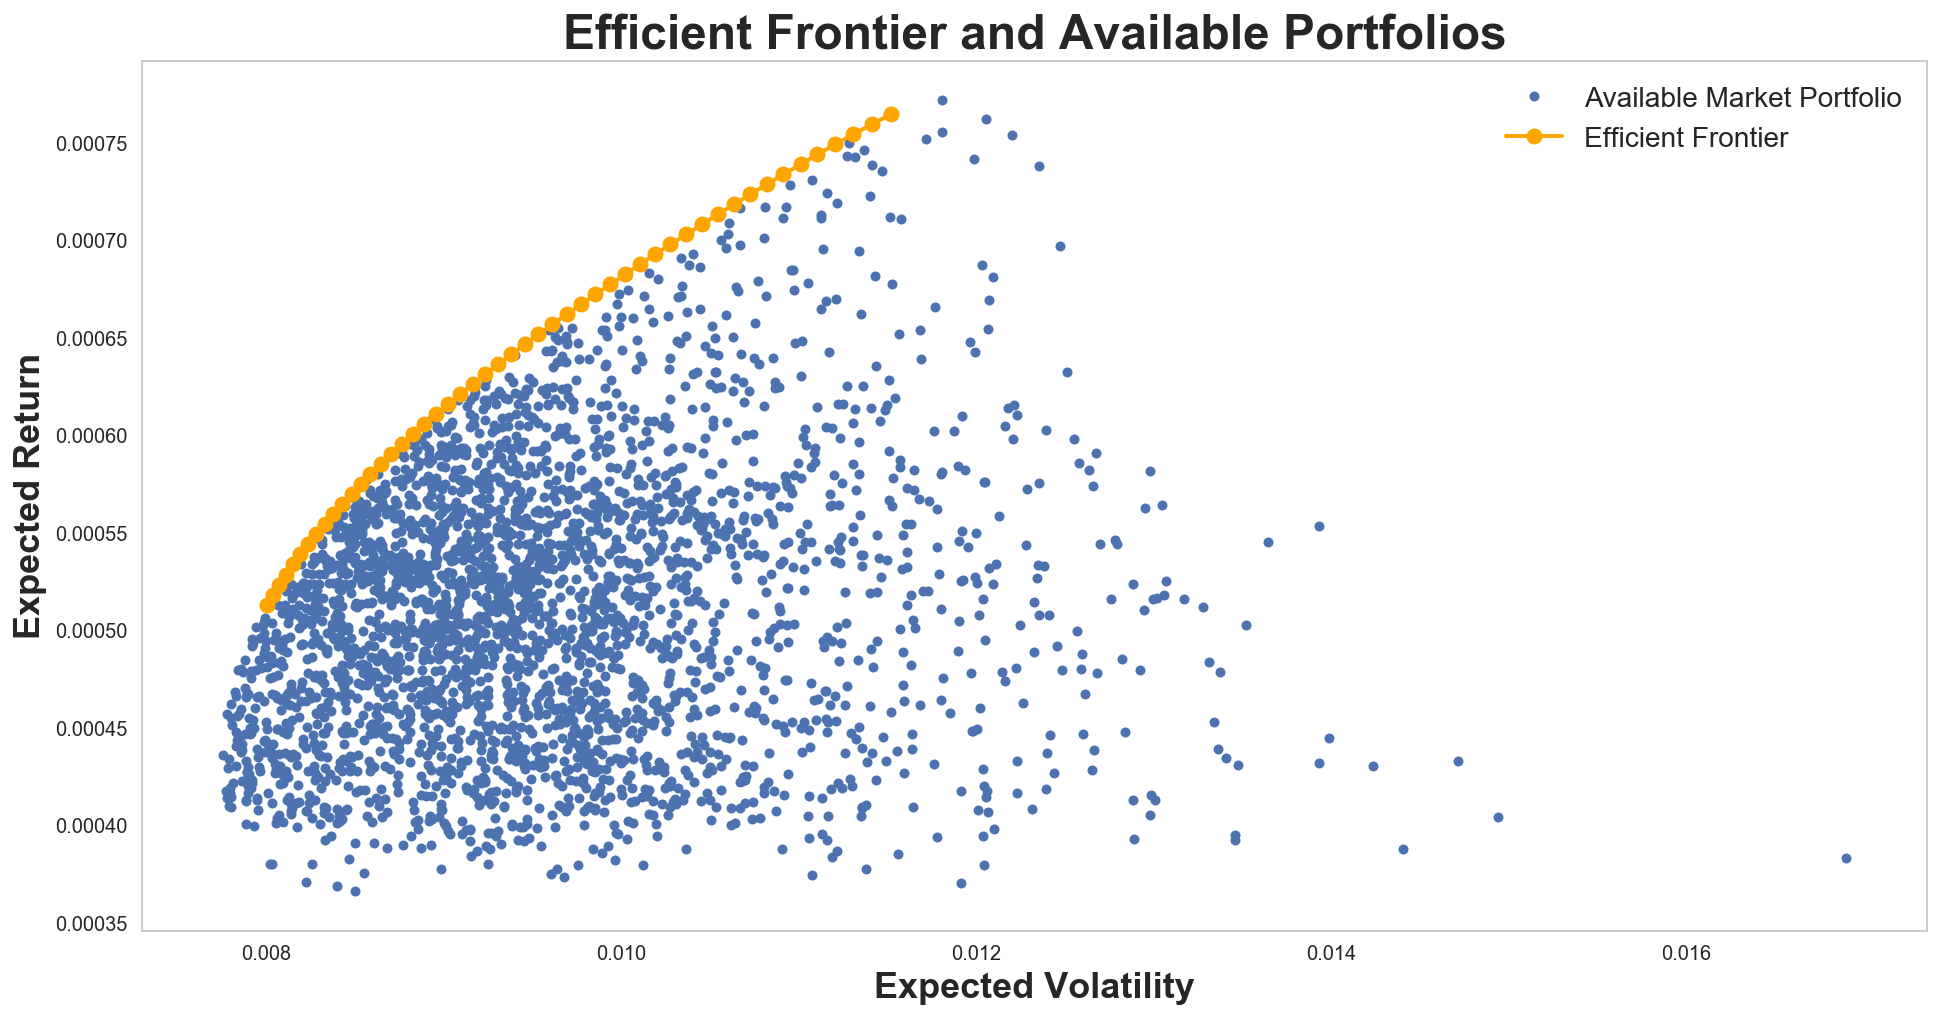

In [60]:
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(optimal_sigmas, optimal_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.savefig('./img/frontier_real.png')
plt.show()

As it can be seen in the plot above, the distribution of available portfolios differs from what we would expect compared to the artificial data case. As mentioned earlier, in a real market data setting the assumption of normaility is likely to be violated which results in a distribution of possible portfolio as above.

You can try this for yourself by using high return Tech stocks like Amazon or Apple. The distribution of the portfolios will look even more structured as one can see an upward trend in the data for those companies instead of the random signal on which MPT relies on.

# Summary

Using Python we were able to plot various portfolios that can be constructed from available stocks in the market. Every financial asset has its own risk and return profile. If financial assets are put into a portfolio we observe diversification effects which led us to the optimization of the corresponding portfolio asset weights to obtain a minimal risk portfolio for a desired level of return.

Modern Portfolio Theory makes many assumptions which are not always correct in a real data setting. Most prominently, the theory assumes that asset returns are normally distributed random variables. Our real data examination indicates this is may not be true given the skewed distribution of available portfolios.

For further discussion on the topic, <a href="https://www.investopedia.com/articles/06/mpt.asp">this Investopedia article of Ben McClure</a> is a very good starter and overview of the modern portfolio theory topic. He also discusses the shortcomings of the model which we have observed in this notebook. href="https://www.investopedia.com/articles/investing/041213/modern-portfolio-theory-vs-behavioral-finance.asp">Lisa Smith's article</a> of MPT and behavioral finance features a nice overview and comparison of the two concepts.

# Resources

* https://en.wikipedia.org/wiki/Modern_portfolio_theory
* https://en.wikipedia.org/wiki/Quadratic_programming
* https://www.codecogs.com/latex/eqneditor.php
* http://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
* http://cvxopt.org/userguide/coneprog.html#quadratic-programming
* https://plot.ly/ipython-notebooks/markowitz-portfolio-optimization/
* https://blog.quantopian.com/markowitz-portfolio-optimization-2/
* http://ahmedas91.github.io/blog/2016/03/01/efficient-frontier-with-python/
* https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
* https://www.investopedia.com/articles/06/mpt.asp
* https://www.investopedia.com/articles/investing/041213/modern-portfolio-theory-vs-behavioral-finance.asp
* http://education.howthemarketworks.com/glossary/modern-portfolio-theory-mpt/
* https://github.com/dacatay/time-series-analysis